In [1]:
import sys 
sys.path.append('C:\\Users\\Nuo.Chen\\PycharmProjects\\Imbalance_price_forecast')
from utils.import_packages import *
# from data_gathering.prepare_data import *

In [21]:
train_df = pd.read_excel(data_folder_path + '/train.xlsx')

In [22]:
train_df.head()

,week,Date,PTE,take_from_system_price,feed_into_system_price,system_purchase_vol,system_sell_vol,system_absolute_vol,DA-price,DateTime,solar_value,solar_maxvalue,solar_minvalue,wind_value,wind_maxvalue,wind_minvalue,DA>TAKE,DA>FEED
0,53,2016-01-01,1,22.43,22.43,-44777,75846,120623,23.86,2016-01-01 00:00:00,0.0,0.0,0.0,297.2600,318.175,267.225,1,1
1,53,2016-01-01,2,26.14,26.14,-58129,31067,89196,23.86,2016-01-01 00:15:00,0.0,0.0,0.0,297.2600,318.175,267.225,0,0
2,53,2016-01-01,3,38.99,38.99,-74481,18434,92915,23.86,2016-01-01 00:30:00,0.0,0.0,0.0,297.2600,318.175,267.225,0,0
3,53,2016-01-01,4,33.02,33.02,-86487,38372,124859,23.86,2016-01-01 00:45:00,0.0,0.0,0.0,297.2600,318.175,267.225,0,0
4,53,2016-01-01,5,32.62,32.62,-58967,52815,111782,22.39,2016-01-01 01:00:00,0.0,0.0,0.0,281.0725,299.825,259.450,0,0


# PTE VS imbalance price

In [30]:
# rearange df into different PTE
pte_list = np.unique( train_df['PTE'] )
pte_dict = {}
# plot imbalance price distribution against different PTE
for pte in pte_list:
    pte_dict[pte] = train_df[train_df['PTE'] == pte]

Text(0,0.5,'Probability')

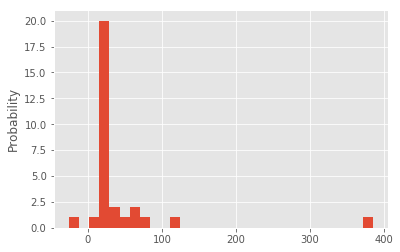

In [60]:
target_month = 9
target_pte = 60

pte_dict = {}
train_df['month'] = train_df['Date'].dt.month
for pte in pte_list:
    pte_dict[pte] = train_df[ (train_df['PTE'] == pte)&(train_df['month'] == target_month) ]
    
pte1_price = pte_dict[target_pte]['take_from_system_price']
plt.hist(pte1_price, normed=False, bins=30)
plt.ylabel('Probability')

In [24]:
train_df['dayOfYear'] = train_df['Date'].dt.dayofyear

In [27]:
train_df.tail()

,week,Date,PTE,take_from_system_price,feed_into_system_price,system_purchase_vol,system_sell_vol,system_absolute_vol,DA-price,DateTime,solar_value,solar_maxvalue,solar_minvalue,wind_value,wind_maxvalue,wind_minvalue,DA>TAKE,DA>FEED,dayOfYear
33207,50,2016-12-11,92,28.08,28.08,-61538,84664,146202,45.464267,2016-12-11 22:45:00,0.0,0.0,0.0,266.195,316.875,227.600,1,1,346
33208,50,2016-12-11,93,30.43,30.43,-86542,59657,146199,44.718500,2016-12-11 23:00:00,0.0,0.0,0.0,312.595,408.175,199.275,1,1,346
33209,50,2016-12-11,94,2.98,2.98,-20441,69649,90090,44.718500,2016-12-11 23:15:00,0.0,0.0,0.0,312.595,408.175,199.275,1,1,346
33210,50,2016-12-11,95,13.27,13.27,-49842,76315,126157,44.718500,2016-12-11 23:30:00,0.0,0.0,0.0,312.595,408.175,199.275,1,1,346
33211,50,2016-12-11,96,25.03,25.03,-63797,89499,153296,44.718500,2016-12-11 23:45:00,0.0,0.0,0.0,312.595,408.175,199.275,1,1,346


# imbalance price plot

In [3]:
train_df[['take_from_system_price', 'feed_into_system_price']].describe()

,take_from_system_price,feed_into_system_price
count,33212.000000,33212.000000
mean,34.636529,31.948144
std,57.588468,55.369811
min,-430.070000,-430.070000
25%,20.740000,20.130000
50%,25.160000,24.350000
75%,32.810000,31.360000
max,546.230000,432.780000


In [4]:
def regression_feat_pipeline(lag_dict, df):
    df = make_date_feature(df)
    # hot-encoding weekday and pte    
    dummy_date = pd.get_dummies(df['weekday'], prefix='weekday')
    dummy_PTE = pd.get_dummies(df['PTE'], prefix = 'PTE')
    df = pd.concat([df, dummy_date, dummy_PTE], axis = 1)
    df.drop(['weekday'], axis=1)

    # lag feat
    for lag_column, lag_value in lag_dict.items():
        lag_feat = make_lag_feat(lag_column, lag_value, df)
        df = pd.concat([df, lag_feat], axis=1)
    
   # standardize
    clasy_cols = ['DA>FEED', 'DA>TAKE', 'Date', 'DateTime','day', 'month','PTE','weekday',
                        'week', 'sin_weekday', 'sin_month', 'sin_day', 'sin_PTE',
                        'take_from_system_price', 'feed_into_system_price']
    clasy_cols.extend(dummy_date.columns)
    clasy_cols.extend(dummy_PTE.columns)

    df= standardize_feat(df, clasy_cols)
    
    # select x,y
    y = df[['DA>FEED', 'DA>TAKE', 'take_from_system_price', 'feed_into_system_price']]    
    X = df.drop(['DA>FEED', 'DA>TAKE', 'take_from_system_price', 'feed_into_system_price',\
                 'DA-price', 'system_purchase_vol', 'system_sell_vol', 'system_absolute_vol',\
                 'DateTime', 'week', 'Date', 'PTE','weekday'], \
                axis=1)
    return X, y

In [5]:
lag_values = {'yesterday': np.arange(96,96*2),\
             'two_days': np.arange(96, 96*3),\
             'same_time_before': [96, 96*2, 96*3],\
             'around_time_before':[96, 97, 95*2, 96*2, 97*2]}
lag_dict = {'take_from_system_price':lag_values['yesterday'],\
           'feed_into_system_price':lag_values['yesterday'],\
           'DA-price':lag_values['around_time_before'],\
           'system_purchase_vol':lag_values['around_time_before'],\
           'system_sell_vol':lag_values['around_time_before'],\
           'system_absolute_vol':lag_values['around_time_before'],\
           'wind_value':lag_values['around_time_before']}

In [6]:
X, Y = regression_feat_pipeline(lag_dict, train_df)

# imbalance price against PTE

In [7]:
train_df.columns

Index(['week', 'Date', 'PTE', 'take_from_system_price',
       'feed_into_system_price', 'system_purchase_vol', 'system_sell_vol',
       'system_absolute_vol', 'DA-price', 'DateTime', 'solar_value',
       'solar_maxvalue', 'solar_minvalue', 'wind_value', 'wind_maxvalue',
       'wind_minvalue', 'DA>TAKE', 'DA>FEED', 'weekday', 'sin_weekday',
       'cos_weekday', 'sin_month', 'cos_month', 'sin_day', 'cos_day',
       'sin_PTE', 'cos_PTE'],
      dtype='object')

In [11]:
list_PTE = np.unique(train_df['PTE'])
df_by_PTE = {}

for pte in list_PTE:
    df_by_PTE[pte] = train_df[train_df['PTE']== pte]


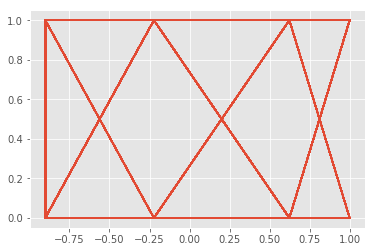

In [16]:
pte_1_imb_price = df_by_PTE[1]['DA>TAKE']
pte_1_weekday = df_by_PTE[1]['cos_weekday']

plt.plot(pte_1_weekday, pte_1_imb_price)

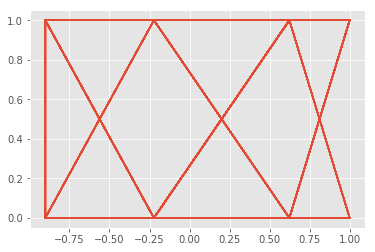

In [20]:
pte_1_imb_price = df_by_PTE[50]['DA>TAKE']
pte_1_weekday = df_by_PTE[50]['cos_weekday']

plt.plot(pte_1_weekday, pte_1_imb_price)

In [9]:
pte_dict

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96], dtype=int64)

In [9]:
X.head()

,solar_value,solar_maxvalue,solar_minvalue,wind_value,wind_maxvalue,wind_minvalue,sin_weekday,cos_weekday,sin_month,cos_month,sin_day,cos_day,sin_PTE,cos_PTE,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,PTE_1,PTE_2,PTE_3,PTE_4,PTE_5,PTE_6,PTE_7,PTE_8,PTE_9,PTE_10,PTE_11,PTE_12,PTE_13,PTE_14,PTE_15,PTE_16,PTE_17,PTE_18,PTE_19,PTE_20,PTE_21,PTE_22,PTE_23,PTE_24,PTE_25,PTE_26,PTE_27,PTE_28,PTE_29,PTE_30,PTE_31,PTE_32,PTE_33,PTE_34,PTE_35,PTE_36,PTE_37,PTE_38,PTE_39,PTE_40,PTE_41,PTE_42,PTE_43,PTE_44,PTE_45,PTE_46,PTE_47,PTE_48,PTE_49,PTE_50,PTE_51,PTE_52,PTE_53,PTE_54,PTE_55,PTE_56,PTE_57,PTE_58,PTE_59,PTE_60,PTE_61,PTE_62,PTE_63,PTE_64,PTE_65,PTE_66,PTE_67,PTE_68,PTE_69,PTE_70,PTE_71,PTE_72,PTE_73,PTE_74,PTE_75,PTE_76,PTE_77,PTE_78,PTE_79,PTE_80,PTE_81,PTE_82,PTE_83,PTE_84,PTE_85,PTE_86,PTE_87,PTE_88,PTE_89,PTE_90,PTE_91,PTE_92,PTE_93,PTE_94,PTE_95,PTE_96,take_from_system_price_96,take_from_system_price_97,take_from_system_price_98,take_from_system_price_99,take_from_system_price_100,take_from_system_price_101,take_from_system_price_102,take_from_system_price_103,take_from_system_price_104,take_from_system_price_105,take_from_system_price_106,take_from_system_price_107,take_from_system_price_108,take_from_system_price_109,take_from_system_price_110,take_from_system_price_111,take_from_system_price_112,take_from_system_price_113,take_from_system_price_114,take_from_system_price_115,take_from_system_price_116,take_from_system_price_117,take_from_system_price_118,take_from_system_price_119,take_from_system_price_120,take_from_system_price_121,take_from_system_price_122,take_from_system_price_123,take_from_system_price_124,take_from_system_price_125,take_from_system_price_126,take_from_system_price_127,take_from_system_price_128,take_from_system_price_129,take_from_system_price_130,take_from_system_price_131,take_from_system_price_132,take_from_system_price_133,take_from_system_price_134,take_from_system_price_135,take_from_system_price_136,take_from_system_price_137,take_from_system_price_138,take_from_system_price_139,take_from_system_price_140,take_from_system_price_141,take_from_system_price_142,take_from_system_price_143,take_from_system_price_144,take_from_system_price_145,take_from_system_price_146,take_from_system_price_147,take_from_system_price_148,take_from_system_price_149,take_from_system_price_150,take_from_system_price_151,take_from_system_price_152,take_from_system_price_153,take_from_system_price_154,take_from_system_price_155,take_from_system_price_156,take_from_system_price_157,take_from_system_price_158,take_from_system_price_159,take_from_system_price_160,take_from_system_price_161,take_from_system_price_162,take_from_system_price_163,take_from_system_price_164,take_from_system_price_165,take_from_system_price_166,take_from_system_price_167,take_from_system_price_168,take_from_system_price_169,take_from_system_price_170,take_from_system_price_171,take_from_system_price_172,take_from_system_price_173,take_from_system_price_174,take_from_system_price_175,take_from_system_price_176,take_from_system_price_177,take_from_system_price_178,take_from_system_price_179,take_from_system_price_180,take_from_system_price_181,take_from_system_price_182,take_from_system_price_183,take_from_system_price_184,take_from_system_price_185,take_from_system_price_186,take_from_system_price_187,take_from_system_price_188,take_from_system_price_189,take_from_system_price_190,take_from_system_price_191,feed_into_system_price_96,feed_into_system_price_97,feed_into_system_price_98,feed_into_system_price_99,feed_into_system_price_100,feed_into_system_price_101,feed_into_system_price_102,feed_into_system_price_103,feed_into_system_price_104,feed_into_system_price_105,feed_into_system_price_106,feed_into_system_price_107,feed_into_system_price_108,feed_into_system_price_109,feed_into_system_price_110,feed_into_system_price_111,feed_into_system_price_112,feed_into_system_price_113,feed_into_system_price_114,feed_into_sy